In [1]:
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
%matplotlib inline

# 1. User input

## 1.1 Enter objective function results

In [2]:
obj1 = pd.read_pickle("Data/obj1")
obj2 = pd.read_pickle("Data/obj2")
obj3 = pd.read_pickle("Data/obj3")

obj1name = obj1.name
obj2name = obj2.name
obj3name = obj3.name

## 1.2 Create dataframe with maximised objectives minimised, for calculating pseudo-weight vectors

In [3]:
pwobjdf = pd.DataFrame.from_items([(obj1name, -obj1), (obj2name, obj2), (obj3name, obj3)])

## 1.3 Enter objective chart names

In [4]:
obj1chartname = 'Minimum Storage (GL) %s' % r'$\longrightarrow$'
obj2chartname = '%s Total Cost (%s million)' % (r'$\longleftarrow$', r'$\$$')
obj3chartname = '%s Total Spill (GL)' % r'$\longleftarrow$'

## 1.4 Enter cluster information

Medoids

In [5]:
medobj1 = pd.read_pickle("Data/medobj1")
medobj2 = pd.read_pickle("Data/medobj2")
medobj3 = pd.read_pickle("Data/medobj3")

Enter index of medoids

In [6]:
medindex = pd.read_pickle("Data/medindex")

Create category to identify medoids for plotting

In [7]:
medcat = {}
for i in range(len(obj1)):
    if any(medindex == i):
        medcat[i] = 1
    else:
        medcat[i] = 0

Enter cluster colour pool

In [8]:
clustercolours = pd.read_pickle("Data/clustercolours")

Enter list of cluster colours for entire Pareto set

In [9]:
clustcollist = pd.read_pickle("Data/clustcollist")

## 1.5 Create dataframe of medoids for calculating pseudo-weights, with maximised objectives negated

In [10]:
pwmedobjdf = pd.DataFrame.from_items([(obj1name, -medobj1), (obj2name, medobj2), (obj3name, medobj3)])

# 2. Pseudo-weight vector function  - note it requires minimised objectives (negate maximised objectives)

Function to calculate pseudo-weight vectors and output to csv

In [11]:
# Function to calculate pseudo-weight vectors for entire Pareto set
# Required input: dataframe of objective function values, columnwise
def pseudoweight(objs,filename):
    results = pd.DataFrame(index = objs.index, columns=objs.columns)
    maximums = {obj: objs[obj].max() for obj in objs}
    minimums = {obj: objs[obj].min() for obj in objs}
    for i in range(0, len(objs)):
        for j in objs.columns:
            numerator = (maximums[j]-objs[j][i])/(maximums[j]-minimums[j])
            results[j][i] = numerator
        results.ix[i] = results.ix[i]/sum(results.ix[i])
    results.to_csv("%s.csv" % filename)
    return results
    
# Function to calculate pseudo-weight vectors for medoids, but in context of entire Pareto set
# Required input: dataframe of objective function values, columnwise; dataframe of objective functions for medoids
def pseudoweightmedoids(objs,medobjs,filename):
    results = pd.DataFrame(index = medobjs.index, columns = medobjs.columns)
    maximums = {obj: objs[obj].max() for obj in objs}
    minimums = {obj: objs[obj].min() for obj in objs}
    for i in range(0, len(medobjs)):
        for j in medobjs.columns:
            numerator = (maximums[j]-medobjs[j][i])/(maximums[j]-minimums[j])
            results[j][i] = numerator
        results.ix[i] = results.ix[i]/sum(results.ix[i])
    results.to_csv("%s.csv" % filename)
    return results

# 3. Execution

## 3.1 Implement pseudo-weight function - note it requires minimised objectives (negate maximised objectives)

In [12]:
# all solutions
pweights = pseudoweight(pwobjdf, 'Pseudo-weight vectors/pseudoweights all')
# medoids only
medoidpweights = pseudoweightmedoids(pwobjdf, pwmedobjdf, 'Pseudo-weight vectors/pseudoweights medoids')

## 3.2 Plot Pareto front with legend of weights

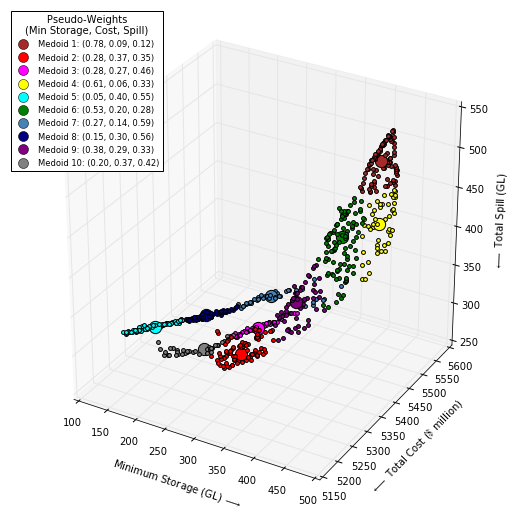

In [13]:
# Create 3d figure
fig = plt.figure(figsize = [7,7])
ax = fig.add_subplot(1,1,1)
ax = Axes3D(fig)

# create markers for medoids ('o') or non-medoids ('.')
markers = {0:'.', 1:'o'}

# create marker size for medoids (60) or non-medoids (150)
marksize = {0: 60, 1: 150}

# create labels for legend
labels = []
for i in medoidpweights.index:
    labs = 'Medoid %d: ('% (i+1)+', '.join(['{:.2f}'.format(x) for x in abs(medoidpweights.ix[i])]) + ')'
    labels.append(labs)

# create points for legend
points = []
for i in medoidpweights.index:
    point = mpl.lines.Line2D([0],[0], marker = 'o', markersize = 10, color = clustercolours[i], linestyle = 'none')
    points.append(point)

# plot each point
for i in obj1.index:
    ax.scatter(obj1[i], obj2[i], obj3[i], c = clustcollist[i], 
               marker = markers[medcat[i]], s = marksize[medcat[i]])

#label axes
ax.set_xlabel(obj1chartname, labelpad = 10)
ax.set_ylabel(obj2chartname, labelpad = 10)
ax.set_zlabel(obj3chartname, labelpad = 10)

# create legend
ax.legend(points, labels, numpoints = 1, loc = 'upper left', fontsize = 'small', 
          title = "       Pseudo-Weights    \n(Min Storage, Cost, Spill)")

plt.savefig('Pseudo-weight vectors/pseudo weights scatter pareto front.png', dpi=150, bbox_inches='tight')

In [14]:
plt.close(fig)

# 4. User input: identify desired medoid

Enter desired medoid based on analysis of pseudo-weight vector plot

In [16]:
# Enter desired medoid here
desmedoid = 6

# Find index (1 is subtracted from medoid number, since Python counts from 0)
desindex = medindex[desmedoid-1]

# Determine which is the desired medoid (1 is added to number of 'Option' as Python counts from 0)
print 'Option %d is Medoid %d with %s %d, %s %d, and %s %d' % (desindex+1, desmedoid, obj1name, obj1[desindex], 
                                                               obj2name, obj2[desindex], obj3name, obj3[desindex])

Option 348 is Medoid 6 with Minimum System Storage (GL) 404, Total Cost ($ million) 5421, and Total Spill Volume (GL) 426
